# Identify & Track Marine Heatwaves on _Unstructured Grid_ using `spot_the_blOb`

## Processing Steps:
1. Fill spatial holes in the binary data, using `dask_image.ndmorph` -- up to `R_fill` cells in radius.
2. Fill gaps in time -- permitting up to `T_fill` missing time slices, while keeping the same blob ID.
3. Filter out small objects -- area less than the bottom `area_filter_quartile` of the size distribution of objects.
4. Identify objects in the binary data, using `dask_image.ndmeasure`.
5. Connect objects across time, applying the following criteria for splitting, merging, and persistence:
    - Connected Blobs must overlap by at least fraction `overlap_threshold` of the smaller blob.
    - Merged Blobs retain their original ID, but partition the child blob based on the parent of the _nearest-neighbour_ cell. 
6. Cluster and reduce the final object ID graph using `scipy.sparse.csgraph.connected_components`.
7. Map the tracked objects into ID-time space for convenient analysis.

N.B.: Exploits parallelised `dask` operations with optimised chunking using `flox` for memory efficiency and speed \
N.N.B.: This example using 40 years of _daily_ outputs at 5km resolution on an Unstructured Grid (15 million cells) using 32 cores takes 
- Full Split/Merge Thresholding & Merge Tracking:  ~40 minutes

In [1]:
import xarray as xr
import dask
from getpass import getuser
from pathlib import Path

import spot_the_blOb as blob
import spot_the_blOb.helper as hpc

In [2]:
# Start Dask Cluster
client = hpc.StartLocalCluster(n_workers=32, n_threads=1)

Memory per Worker: 7.86 GB


/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36239 instead
  warnings.warn(


Hostname is  l10241
Forward Port = l10241:36239
Dashboard Link: localhost:36239/status


In [3]:
# Load Pre-processed Data (cf. `01_preprocess_extremes.ipynb`)

file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'extreme_events_binary_unstruct.zarr'
chunk_size = {'time': 4, 'ncells': -1}
ds = xr.open_zarr(str(file_name), chunks={}).isel(time=slice(0,128)).chunk(chunk_size)

In [4]:
# Tracking Parameters

drop_area_quartile = 0.8  # Remove the smallest 80% of the identified blobs
hole_filling_radius = 32   # Fill small holes with radius < 8 elements
time_gap_fill = 2         # Allow gaps of 2 days and still continue the blob tracking with the same ID
allow_merging = True      # Allow blobs to split/merge. Keeps track of merge events & unique IDs.
overlap_threshold = 0.5   # Overlap threshold for merging blobs. If overlap < threshold, blobs keep independent IDs.
nn_partitioning = True    # Use new NN method to partition merged children blobs. If False, reverts to old method of Di Sun et al. 2023...

In [5]:
# SpOt & Track the Blobs & Merger Events

tracker = blob.Spotter(ds.extreme_events, ds.mask, R_fill=hole_filling_radius, T_fill = time_gap_fill, area_filter_quartile=drop_area_quartile, 
                       allow_merging=allow_merging, overlap_threshold=overlap_threshold, nn_partitioning=nn_partitioning, 
                       xdim='ncells',               # Need to tell spot_the_blOb the new Unstructured dimension
                       unstructured_grid=True,      # Use Unstructured Grid
                       neighbours=ds.neighbours,    # Connectivity array for the Unstructured Grid
                       cell_areas=ds.cell_areas)      # Cell areas for each Unstructured Grid cell
# blobs = tracker.run(return_merges=False)

# blobs

Constructing the Sparse Dilation Matrix...


In [6]:
data_bin_filled = tracker.fill_holes(tracker.data_bin).persist()
data_bin_filled

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 680.73 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


<xarray.DataArray (time: 128, ncells: 14886338)> Size: 2GB
dask.array<transpose, shape=(128, 14886338), dtype=bool, chunksize=(4, 14886338), chunktype=numpy.ndarray>
Coordinates:
    lat      (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
    lon      (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
  * time     (time) datetime64[ns] 1kB 2002-04-11T23:59:00 ... 2002-08-16T23:...
Dimensions without coordinates: ncells

In [7]:
data_bin_gap_filled = tracker.fill_time_gaps(data_bin_filled).persist()
data_bin_gap_filled

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 680.87 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


<xarray.DataArray (time: 128, ncells: 14886338)> Size: 2GB
dask.array<transpose, shape=(128, 14886338), dtype=bool, chunksize=(4, 14886338), chunktype=numpy.ndarray>
Coordinates:
    lat      (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
    lon      (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
  * time     (time) datetime64[ns] 1kB 2002-04-11T23:59:00 ... 2002-08-16T23:...
Dimensions without coordinates: ncells

(<GeoAxes: title={'right': '2002-04-11T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff667257df0>])

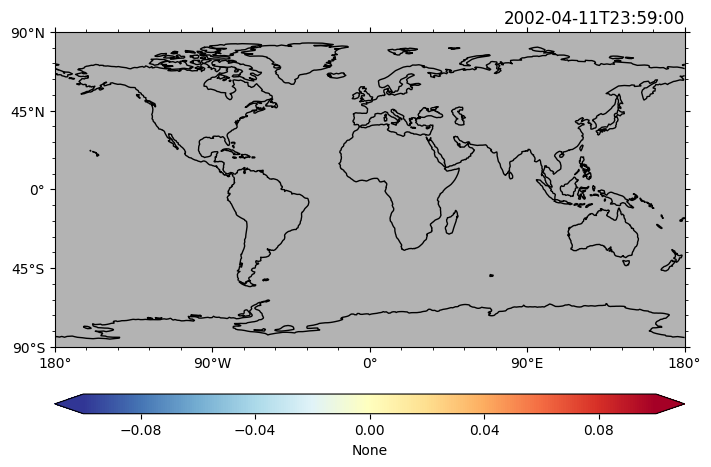

In [78]:
data_bin_gap_filled.isel(time=0).pyic.plot()

In [ ]:
data_bin_filtered, area_threshold, blob_areas, N_blobs_unfiltered = tracker.filter_small_blobs(data_bin_gap_filled)

In [9]:
data_bin_filtered = data_bin_filtered.persist()
data_bin_filtered

<xarray.DataArray 'ID_field' (time: 128, ncells: 14886338)> Size: 2GB
dask.array<transpose, shape=(128, 14886338), dtype=bool, chunksize=(4, 14886338), chunktype=numpy.ndarray>
Coordinates:
    lat      (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
    lon      (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
  * time     (time) datetime64[ns] 1kB 2002-04-11T23:59:00 ... 2002-08-16T23:...
Dimensions without coordinates: ncells

(<GeoAxes: title={'right': '2002-04-11T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff678167a00>])

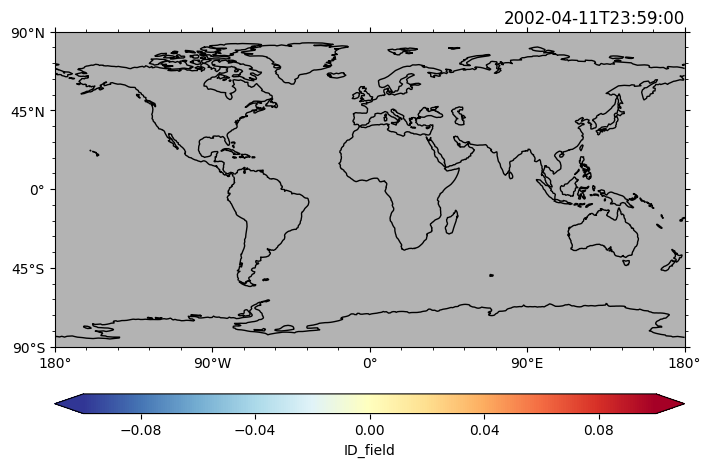

In [74]:
data_bin_filtered.isel(time=0).pyic.plot()

In [10]:
import pyicon as pyic
import numpy as np

----Start loading pyicon.
----Start loading pyicon.
----Pyicon was loaded successfully.
----Pyicon was loaded successfully.


In [11]:
#### Track_blObs....
###############


blob_id_field, _ = tracker.identify_blobs(data_bin_filtered, time_connectivity=False)

In [12]:
blob_id_field = blob_id_field.persist()
blob_id_field

<xarray.DataArray 'ID_field' (time: 128, ncells: 14886338)> Size: 8GB
dask.array<where, shape=(128, 14886338), dtype=int32, chunksize=(4, 14886338), chunktype=numpy.ndarray>
Coordinates:
    lat      (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
    lon      (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
  * time     (time) datetime64[ns] 1kB 2002-04-11T23:59:00 ... 2002-08-16T23:...
Dimensions without coordinates: ncells

In [13]:
cumsum_ids = (blob_id_field.max(dim=tracker.xdim)).cumsum(tracker.timedim)
blob_id_field = xr.where(blob_id_field > 0, blob_id_field + cumsum_ids, 0)

In [14]:
blob_id_field = blob_id_field.persist()

(<GeoAxes: title={'right': '2002-04-16T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff6b576b940>])

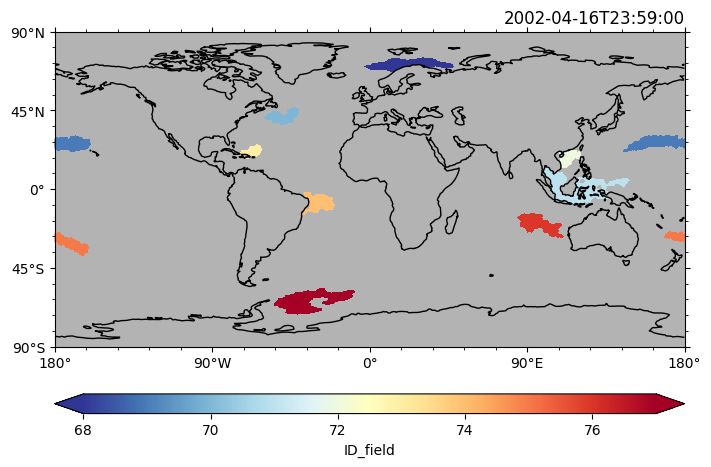

In [15]:
blob_id_field.isel(time=5).pyic.plot()

In [16]:
blob_id_field

<xarray.DataArray 'ID_field' (time: 128, ncells: 14886338)> Size: 15GB
dask.array<where, shape=(128, 14886338), dtype=int64, chunksize=(4, 14886338), chunktype=numpy.ndarray>
Coordinates:
    lat      (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
    lon      (ncells) float64 119MB dask.array<chunksize=(14886338,), meta=np.ndarray>
  * time     (time) datetime64[ns] 1kB 2002-04-11T23:59:00 ... 2002-08-16T23:...
Dimensions without coordinates: ncells

In [17]:
max_ID = blob_id_field.max().compute().item()+1
lat_rad = np.radians(blob_id_field.lat)
lon_rad = np.radians(blob_id_field.lon)

In [55]:
def blob_properties_chunk(ids, lat, lon, area):
    ## Efficient Vectorised Calculation over all IDs in the present chunk
    # N.B.: lat/lon in radians now
    
    valid_mask = ids > 0
    min_ID_chunk = ids[valid_mask].min()
    max_ID_chunk = ids.max()
    n_ids = max_ID_chunk - min_ID_chunk + 1
    
    
    # Convert to Cartesian
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    
    mapped_indices = ids[valid_mask] - min_ID_chunk
    
    # Compute Areas
    total_areas = np.zeros(n_ids, dtype=np.float32)
    np.add.at(total_areas, mapped_indices, area[valid_mask])
    
    # Compute weighted coordinates
    weighted_x = np.zeros(n_ids, dtype=np.float32)
    weighted_y = np.zeros(n_ids, dtype=np.float32)
    weighted_z = np.zeros(n_ids, dtype=np.float32)
    
    np.add.at(weighted_x, mapped_indices, area[valid_mask] * x[valid_mask])
    np.add.at(weighted_y, mapped_indices, area[valid_mask] * y[valid_mask])
    np.add.at(weighted_z, mapped_indices, area[valid_mask] * z[valid_mask])
    
    # Normalise vectors
    norm = np.sqrt(weighted_x**2 + weighted_y**2 + weighted_z**2)
    weighted_x /= norm
    weighted_y /= norm
    weighted_z /= norm
    
    # Convert back to lat/lon
    centroid_lat = np.degrees(np.arcsin(weighted_z))
    centroid_lon = np.degrees(np.arctan2(weighted_y, weighted_x))
    
    # Fix longitude range to [-180, 180]
    centroid_lon = np.where(centroid_lon > 180., centroid_lon - 360.,
                            np.where(centroid_lon < -180., centroid_lon + 360.,  
                            centroid_lon))
    
    # Initialise arrays for results
    output_props = np.zeros((3, max_ID), dtype=np.float32)
    
    # Put into full arrays
    output_props[0, min_ID_chunk:max_ID_chunk+1] = total_areas
    output_props[1, min_ID_chunk:max_ID_chunk+1] = centroid_lat
    output_props[2, min_ID_chunk:max_ID_chunk+1] = centroid_lon
    
    # centroid-0 is nv=0 is lat
    return output_props

In [72]:
props_array = blob_properties_chunk(blob_id_field.isel(time=0).values, lat_rad.values, lon_rad.values, tracker.cell_area.values)

ValueError: zero-size array to reduction operation minimum which has no identity

(<GeoAxes: title={'right': '2002-04-11T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff678103100>])

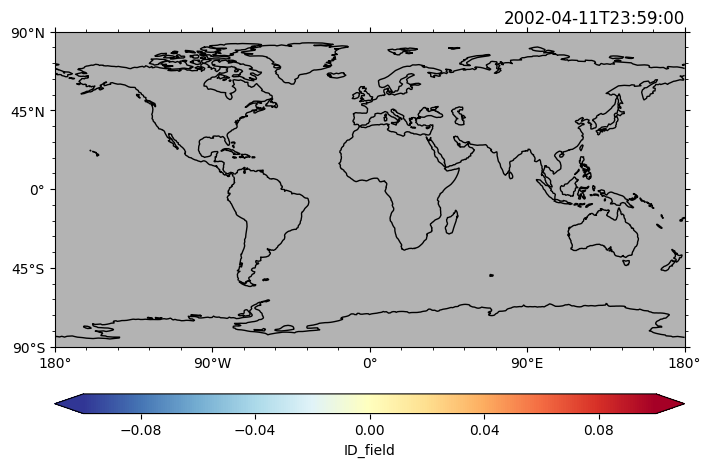

In [73]:
blob_id_field.isel(time=0).pyic.plot()

In [60]:
props_array = xr.apply_ufunc(blob_properties_chunk, blob_id_field,
                                                lat_rad,
                                                lon_rad,
                                                tracker.cell_area,
                                                input_core_dims=[[tracker.xdim], [tracker.xdim], [tracker.xdim], [tracker.xdim]],
                                                output_core_dims=[['prop', 'ID']],
                                                output_dtypes=[np.float32],
                                                output_sizes={'prop': 3, 'ID': max_ID}, 
                                                vectorize=True,
                                                dask='parallelized').sum(dim=tracker.timedim)

/tmp/ipykernel_3147247/171512187.py:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  props_array = xr.apply_ufunc(blob_properties_chunk, blob_id_field,


In [61]:
props_array

<xarray.DataArray (prop: 3, ID: 1420)> Size: 17kB
dask.array<sum-aggregate, shape=(3, 1420), dtype=float32, chunksize=(3, 1420), chunktype=numpy.ndarray>
Dimensions without coordinates: prop, ID

In [64]:
blob_props = xr.Dataset({'area': ('ID', props_array.isel(prop=0).data),
                                     'centroid-0': ('ID', props_array.isel(prop=1).data),
                                     'centroid-1': ('ID', props_array.isel(prop=2).data)},
                                    coords={'ID': np.arange(0, max_ID)})

In [65]:
blob_props['centroid'] = xr.concat([blob_props['centroid-0'], blob_props['centroid-1']], dim='component')
blob_props = blob_props.drop_vars(['centroid-0', 'centroid-1'])

In [ ]:
blob_props = blob_props.persist()

2025-01-21 08:10:16,103 - distributed.worker - ERROR - Compute Failed
Key:       ('vectorize_blob_properties_chunk-vectorize_blob_properties_chunk_0-sum-cd55de5a4076e8660aa1dc3bd599bbe6', 0, 0, 0)
State:     executing
Task:  <Task ('vectorize_blob_properties_chunk-vectorize_blob_properties_chunk_0-sum-cd55de5a4076e8660aa1dc3bd599bbe6', 0, 0, 0) _execute_subgraph(...)>
Exception: "ValueError('zero-size array to reduction operation minimum which has no identity')"
Traceback: '  File "/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py", line 2372, in __call__\n    return self._call_as_normal(*args, **kwargs)\n  File "/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py", line 2365, in _call_as_normal\n    return self._vectorize_call(func=func, args=vargs)\n  File "/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py", line 2446, in _vectorize_call\n    res = self._vectorize_call_with_signa

In [ ]:
# Save Tracked Blobs to `zarr` for more efficient parallel I/O

file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'MHWs_tracked_unstruct.zarr'
blobs.to_zarr(file_name, mode='w')